<a href="https://colab.research.google.com/github/LucasWanderleyGomes/C-lculo-de-M-tricas-de-Avalia-o-de-Aprendizado/blob/main/C%C3%A1lculo_de_M%C3%A9tricas_de_Avalia%C3%A7%C3%A3o_de_Aprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto: Matriz de Confusão + Métricas com Keras (MNIST)
**Objetivo:** Treinar um modelo simples com Keras (TensorFlow), gerar a matriz de confusão e calcular métricas (Acurácia, Precisão, Sensibilidade/Recall, Especificidade e F1) *por classe* a partir da matriz.

Este notebook:
- Carrega e prepara o dataset MNIST;
- Treina uma CNN simples;
- Gera e plota a matriz de confusão (bruta e normalizada);
- Calcula VP, VN, FP, FN por classe e as métricas pedidas;
- Mostra os resultados em um `DataFrame` e compara com `classification_report`.




In [ ]:
# ============ Setup ============
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.metrics import confusion_matrix, classification_report

# Fixar seeds para resultados reproduzíveis (até certo ponto)
np.random.seed(42)
tf.random.set_seed(42)

print("Numpy:", np.__version__)
print("Pandas:", pd.__version__)
print("TensorFlow:", tf.__version__)
print("Seaborn:", sns.__version__)


Numpy: 2.0.2
Pandas: 2.2.2
TensorFlow: 2.19.0
Seaborn: 0.13.2


## 1) O dataset MNIST
MNIST tem 60k imagens de treino e 10k de teste (dígitos 0-9, 28x28 pixels).  
Vamos usar o dataset original do Keras, normalizar os pixels para [0,1] e preparar para uma CNN (channel=1).


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shapes: (60000, 28, 28, 1) (60000,) (10000, 28, 28, 1) (10000,)


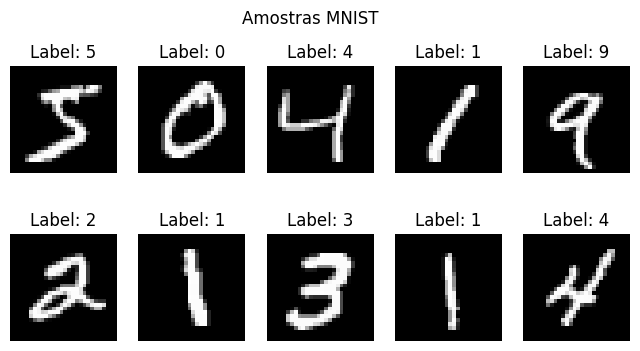

In [ ]:
# ============ Carregar dados ============
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

# Normalizar
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

# Adicionar canal
X_train = X_train[..., np.newaxis]  # shape (60000, 28, 28, 1)
X_test  = X_test[..., np.newaxis]

print("Shapes:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Visualizar algumas imagens
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.suptitle("Amostras MNIST")
plt.show()


## 2) Pré-processamento rápido
- Já normalizamos (0-1).
- Não faremos *one-hot* para o loss `sparse_categorical_crossentropy` — deixa a vida mais simples.
- Se quiser reduzir treinamento: diminua `epochs` ou use uma subamostra do dataset.


In [ ]:
# ============ Criar modelo ============
modelo = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

modelo.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

modelo.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## 3) Treinamento


In [ ]:
# ============ Treinar ============
history = modelo.fit(X_train, y_train,
                     epochs=10,
                     batch_size=128,
                     validation_split=0.1,
                     verbose=2)


Epoch 1/10
422/422 - 44s - 103ms/step - accuracy: 0.9254 - loss: 0.2598 - val_accuracy: 0.9808 - val_loss: 0.0685
Epoch 2/10
422/422 - 40s - 95ms/step - accuracy: 0.9792 - loss: 0.0690 - val_accuracy: 0.9862 - val_loss: 0.0500
Epoch 3/10
422/422 - 42s - 99ms/step - accuracy: 0.9857 - loss: 0.0478 - val_accuracy: 0.9885 - val_loss: 0.0424
Epoch 4/10
422/422 - 81s - 192ms/step - accuracy: 0.9883 - loss: 0.0371 - val_accuracy: 0.9892 - val_loss: 0.0375
Epoch 5/10
422/422 - 40s - 94ms/step - accuracy: 0.9909 - loss: 0.0305 - val_accuracy: 0.9895 - val_loss: 0.0366
Epoch 6/10
422/422 - 39s - 93ms/step - accuracy: 0.9927 - loss: 0.0244 - val_accuracy: 0.9888 - val_loss: 0.0396
Epoch 7/10
422/422 - 40s - 95ms/step - accuracy: 0.9946 - loss: 0.0194 - val_accuracy: 0.9898 - val_loss: 0.0397
Epoch 8/10
422/422 - 39s - 93ms/step - accuracy: 0.9954 - loss: 0.0165 - val_accuracy: 0.9890 - val_loss: 0.0423
Epoch 9/10
422/422 - 39s - 92ms/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.9893 

## 4) Avaliação e predições
Avaliaremos no conjunto de teste e vamos gerar as previsões  para construir a matriz de confusão.


In [ ]:
# ============ Avaliar ============
loss, acc = modelo.evaluate(X_test, y_test, verbose=2)
print(f"\nLoss no teste: {loss:.4f} | Acurácia no teste: {acc:.4f}")

# Predições (probabilidades -> rótulo)
y_pred_probs = modelo.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)


313/313 - 2s - 8ms/step - accuracy: 0.9899 - loss: 0.0323

Loss no teste: 0.0323 | Acurácia no teste: 0.9899
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


## 5) Matriz de Confusão
Vamos calcular a matriz de confusão 10x10 (verdadeiros x preditos), plotá-la e fazer a versão normalizada (% por linha).


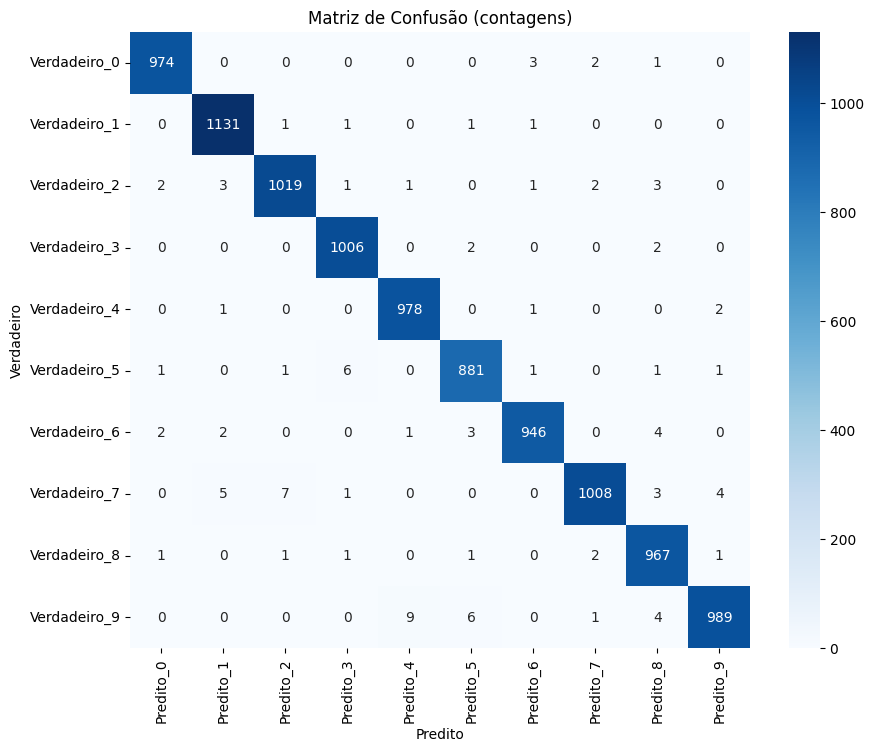

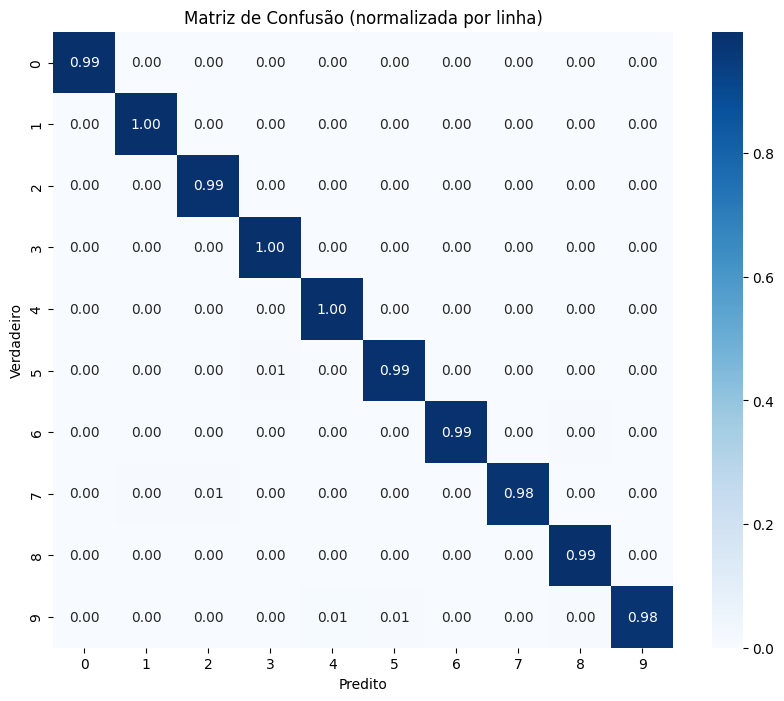

In [ ]:
# ============ Matriz de confusão ============
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Verdadeiro_{i}" for i in range(10)],
                         columns=[f"Predito_{i}" for i in range(10)])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão (contagens)")
plt.ylabel("Verdadeiro")
plt.xlabel("Predito")
plt.show()

# Normalizada por linha (recall por classe)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
plt.title("Matriz de Confusão (normalizada por linha)")
plt.ylabel("Verdadeiro")
plt.xlabel("Predito")
plt.show()


## 6) Calcular VP, VN, FP, FN e métricas por classe (automaticamente)
Explicando:
- Para cada classe `i`:
  - VP = cm[i,i]
  - FN = sum da linha i (todos rótulos verdadeiros i) - VP
  - FP = sum da coluna i (todos preditos como i) - VP
  - VN = total - (VP + FN + FP)
Com esses valores calculamos: Acurácia (por classe), Precisão, Recall, Especificidade e F1.


In [ ]:
# ============ Função para calcular métricas por classe ============
def metrics_from_confusion_matrix(cm):
    classes = cm.shape[0]
    total = cm.sum()
    rowsum = cm.sum(axis=1)
    colsum = cm.sum(axis=0)

    results = []
    for i in range(classes):
        VP = int(cm[i,i])
        FN = int(rowsum[i] - VP)
        FP = int(colsum[i] - VP)
        VN = int(total - (VP + FN + FP))

        # Métricas
        acc = (VP + VN) / total if total != 0 else 0
        prec = VP / (VP + FP) if (VP + FP) != 0 else 0
        rec = VP / (VP + FN) if (VP + FN) != 0 else 0
        spec = VN / (VN + FP) if (VN + FP) != 0 else 0
        f1 = 2 * (prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        results.append({
            "classe": i,
            "VP": VP, "VN": VN, "FP": FP, "FN": FN,
            "acuracia_por_classe": acc,
            "precisao": prec,
            "recall": rec,
            "especificidade": spec,
            "f1": f1,
            "support": int(rowsum[i])
        })

    df = pd.DataFrame(results)
    # formatar com casas decimais
    df[["acuracia_por_classe","precisao","recall","especificidade","f1"]] = df[["acuracia_por_classe","precisao","recall","especificidade","f1"]].round(4)
    return df

metrics_df = metrics_from_confusion_matrix(cm)
metrics_df


,classe,VP,VN,FP,FN,acuracia_por_classe,precisao,recall,especificidade,f1,support
0,0,974,9014,6,6,0.9988,0.9939,0.9939,0.9993,0.9939,980
1,1,1131,8854,11,4,0.9985,0.9904,0.9965,0.9988,0.9934,1135
2,2,1019,8958,10,13,0.9977,0.9903,0.9874,0.9989,0.9888,1032
3,3,1006,8980,10,4,0.9986,0.9902,0.9960,0.9989,0.9931,1010
4,4,978,9007,11,4,0.9985,0.9889,0.9959,0.9988,0.9924,982
5,5,881,9095,13,11,0.9976,0.9855,0.9877,0.9986,0.9866,892
6,6,946,9035,7,12,0.9981,0.9927,0.9875,0.9992,0.9901,958
7,7,1008,8965,7,20,0.9973,0.9931,0.9805,0.9992,0.9868,1028
8,8,967,9008,18,7,0.9975,0.9817,0.9928,0.9980,0.9872,974
9,9,989,8983,8,20,0.9972,0.9920,0.9802,0.9991,0.9860,1009


## 7) Médias (macro / weighted) e comparação com `classification_report`
- **Macro**: média simples das métricas por classe.
- **Weighted**: média ponderada pelo `support` (número de exemplos por classe).
Também mostramos o `classification_report` do sklearn (precisão/recall/f1 já conhecidos).


In [ ]:
# Médias manualmente
macro = metrics_df[["precisao","recall","f1"]].mean().rename("macro")
weighted = (metrics_df[["precisao","recall","f1"]].mul(metrics_df["support"], axis=0).sum() / metrics_df["support"].sum()).rename("weighted")

print("Médias (macro):")
print(macro.to_frame().T)
print("\nMédias (weighted):")
print(weighted.to_frame().T)

# classification_report (sklearn)
print("\nclassification_report (sklearn):")
print(classification_report(y_test, y_pred, digits=4))


Médias (macro):
       precisao   recall       f1
macro   0.98987  0.98984  0.98983

Médias (weighted):
          precisao  recall        f1
weighted   0.98994  0.9899  0.989894

classification_report (sklearn):
              precision    recall  f1-score   support

           0     0.9939    0.9939    0.9939       980
           1     0.9904    0.9965    0.9934      1135
           2     0.9903    0.9874    0.9888      1032
           3     0.9902    0.9960    0.9931      1010
           4     0.9889    0.9959    0.9924       982
           5     0.9855    0.9877    0.9866       892
           6     0.9927    0.9875    0.9901       958
           7     0.9931    0.9805    0.9868      1028
           8     0.9817    0.9928    0.9872       974
           9     0.9920    0.9802    0.9860      1009

    accuracy                         0.9899     10000
   macro avg     0.9898    0.9898    0.9898     10000
weighted avg     0.9899    0.9899    0.9899     10000

